# Load Data

In [27]:
import pandas as pd
import zipfile
import os

def read_from_zip(file_name, zip_filename="ieee-fraud-detection.zip", **kwargs):
    """
    Reads a specific CSV file from a zip archive located in the 'data/' directory.

    Args:
        file_name (str): The name of the CSV to load (e.g., 'train_transaction').
        zip_filename (str): The name of the zip archive.

    Returns:
        pandas.DataFrame: The loaded data, or None if the file is not found.
    """
    # Construct a relative path to the data directory.
    # This assumes your 'data' folder is at the project root.
    # From 'tests/notebooks/', we go up two levels to the project root.
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    zip_path = os.path.join(project_root, 'data/input_data/ieee_fraud_detection', zip_filename)
    print("Reading from zip archive: {}".format(zip_path))

    csv_file_to_read = f"{file_name}.csv"

    if not os.path.exists(zip_path):
        print(f"Error: Zip file not found at '{zip_path}'")
        return None

    try:
        # Open the zip file
        with zipfile.ZipFile(zip_path) as z:
            # Open the specific CSV file within the zip
            with z.open(csv_file_to_read) as f:
                print(f"Reading '{csv_file_to_read}' from '{zip_filename}'...")
                if kwargs:
                    if "usecols" in kwargs:
                        df = pd.read_csv(f, index_col=kwargs['index_col'], dtype=kwargs['dtype'], usecols = kwargs['usecols'])
                        print("Data loaded successfully.")
                        return df
                    else:
                        df = pd.read_csv(f, index_col=kwargs['index_col'], dtype=kwargs['dtype'])
                        print("Data loaded successfully.")
                        return df
                else:
                    # Read the dataset using pandas
                    df = pd.read_csv(f)
                    print("Data loaded successfully.")
                    return df
    except KeyError:
        print(f"Error: File '{csv_file_to_read}' not found inside the zip archive.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [7]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30',
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [28]:
read_from_zip(file_name="train_transaction", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])

Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'train_transaction.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,0,86400.0,68.500000,W,13926.0,NaN,150.0,discover,142.0,credit,...,0.0,0.0,0.0,0.0,1.0,117.000000,0.0,0.000000,0.000000,0.000000
2987001.0,0,86401.0,29.000000,W,2755.0,404.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
2987002.0,0,86469.0,59.000000,W,4663.0,490.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
2987003.0,0,86499.0,50.000000,W,18132.0,567.0,150.0,mastercard,117.0,debit,...,0.0,0.0,0.0,0.0,1.0,1758.000000,0.0,354.000000,0.000000,0.000000
2987004.0,0,86506.0,50.000000,H,4497.0,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535.0,0,15811047.0,49.000000,W,6550.0,NaN,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,1.0,47.950001,0.0,47.950001,47.950001,0.000000
3577536.0,0,15811049.0,39.500000,W,10444.0,225.0,150.0,mastercard,224.0,debit,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
3577537.0,0,15811079.0,30.950001,W,12037.0,595.0,150.0,mastercard,224.0,debit,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000


In [29]:
read_from_zip(file_name="train_identity", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes)


Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'train_identity.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008.0,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010.0,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011.0,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016.0,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577521.0,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
3577526.0,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
3577529.0,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152


In [22]:
read_from_zip(file_name="test_transaction", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes, usecols=cols)

Reading 'test_transaction.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549.0,18403224.0,31.950001,W,10409.0,111.0,150.0,visa,226.0,debit,170.0,...,0.0,0.0,0.0,0.0,1.0,47.950001,0.000000,47.950001,0.000000,0.0
3663550.0,18403264.0,49.000000,W,4272.0,111.0,150.0,visa,226.0,debit,299.0,...,0.0,0.0,0.0,0.0,1.0,280.000000,0.000000,280.000000,0.000000,0.0
3663551.0,18403310.0,171.000000,W,4476.0,574.0,150.0,visa,226.0,debit,472.0,...,2.0,0.0,0.0,0.0,1.0,1321.000000,0.000000,1058.000000,0.000000,263.0
3663552.0,18403310.0,284.950012,W,10989.0,360.0,150.0,visa,166.0,debit,205.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,282.540009,0.0
3663553.0,18403316.0,67.949997,W,18018.0,452.0,150.0,mastercard,117.0,debit,264.0,...,0.0,0.0,0.0,0.0,1.0,183.850006,67.949997,183.850006,183.850006,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235.0,34214280.0,94.679001,C,13832.0,375.0,185.0,mastercard,224.0,debit,284.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
4170236.0,34214288.0,12.173000,C,3154.0,408.0,185.0,mastercard,224.0,debit,NaN,...,0.0,0.0,0.0,2.0,1.0,31.723700,0.000000,31.723700,31.723700,0.0
4170237.0,34214328.0,49.000000,W,16661.0,490.0,150.0,visa,226.0,debit,327.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0


In [30]:
read_from_zip(file_name="test_identity", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes)

Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'test_identity.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.


,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663586.0,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663588.0,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
3663597.0,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3663601.0,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663602.0,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170230.0,-20.0,473365.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J700M
4170233.0,-5.0,489917.0,0.0,0.0,-4.0,-32.0,NaN,NaN,0.0,0.0,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J320M
4170234.0,-5.0,110081.0,NaN,NaN,22.0,-31.0,NaN,NaN,NaN,NaN,...,mobile safari 10.0,32.0,1334x750,match_status:2,T,F,F,T,mobile,iOS Device


In [31]:
%%time
# LOAD TRAIN
# X_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
X_train = read_from_zip(file_name="train_transaction", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
# train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
train_id = read_from_zip(file_name="train_identity", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# LOAD TEST
# X_test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
X_test = read_from_zip(file_name="test_transaction", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes, usecols=cols)
# test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
test_id = read_from_zip(file_name="test_identity", zip_filename="ieee-fraud-detection.zip", index_col='TransactionID', dtype=dtypes)

fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)


Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'train_transaction.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.
Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'train_identity.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.
Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'test_transaction.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.
Reading from zip archive: C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\data/input_data/ieee_fraud_detection\ieee-fraud-detection.zip
Reading 'test_identity.csv' from 'ieee-fraud-detection.zip'...
Data loaded successfully.
Train shape (590540, 213) test shape (506691, 21

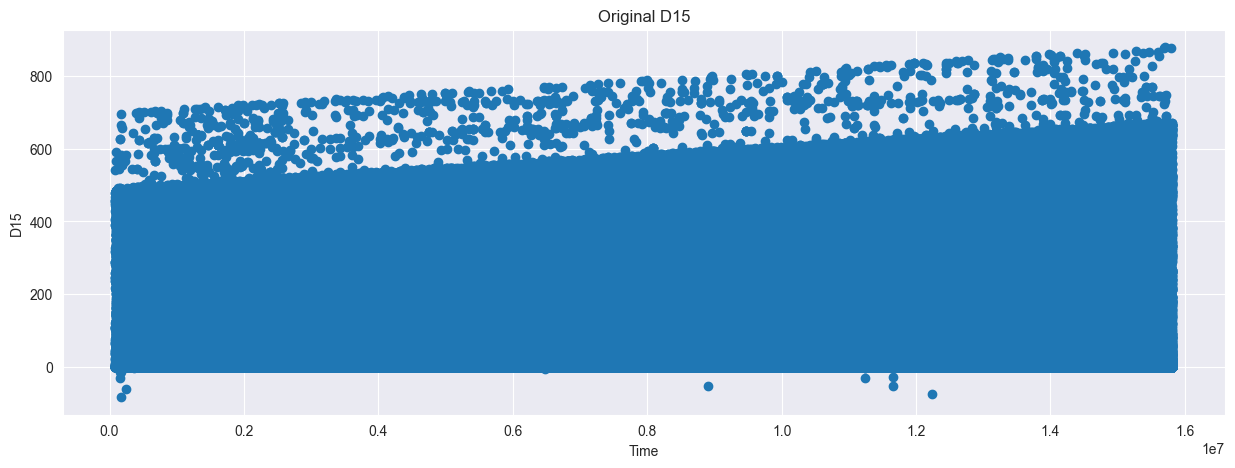

In [32]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [33]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

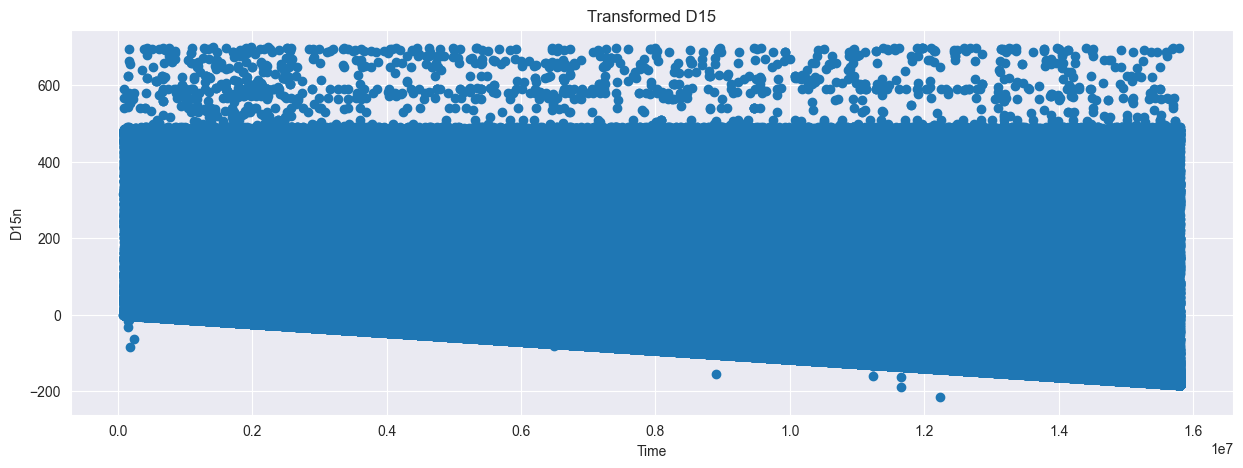

In [35]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [37]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'):
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

<timed exec>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, t

CPU times: total: 2.83 s
Wall time: 2.92 s


In [38]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [39]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Marco\AppData\Local\Temp\ipykern

cents, addr1_FE , card1_FE , card2_FE , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

card3_FE , P_emaildomain_FE , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1 , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , card1_addr1_FE , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tr

'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'TransactionAmt_card1_addr1_std' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'TransactionAmt_card1_addr1_P_emaildomain_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D9_card1_addr1_P_emaildomain_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D11_card1_std' , 'D11_card1_addr1_mean' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D11_card1_addr1_std' , 

C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: total: 6.7 s
Wall time: 7.06 s


C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Marco\AppData\Local\Temp\ipykernel_28996\1968470052.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assig

In [40]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [41]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [42]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [45]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist',
        early_stopping_rounds=100
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT],
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50)

XGBoost version: 3.0.5


C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [09:24:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-auc:0.82036
[50]	validation_0-auc:0.90457
[100]	validation_0-auc:0.91766
[150]	validation_0-auc:0.92524
[200]	validation_0-auc:0.93062
[250]	validation_0-auc:0.93365
[300]	validation_0-auc:0.93512
[350]	validation_0-auc:0.93582
[400]	validation_0-auc:0.93654
[450]	validation_0-auc:0.93667
[500]	validation_0-auc:0.93641
[550]	validation_0-auc:0.93639
[569]	validation_0-auc:0.93634


C:\Users\Marco\PycharmProjects\fraud_detection_adversarial\.venv\Lib\site-packages\xgboost\sklearn.py:1479: UserWarning: [09:25:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  score = b.get_score(


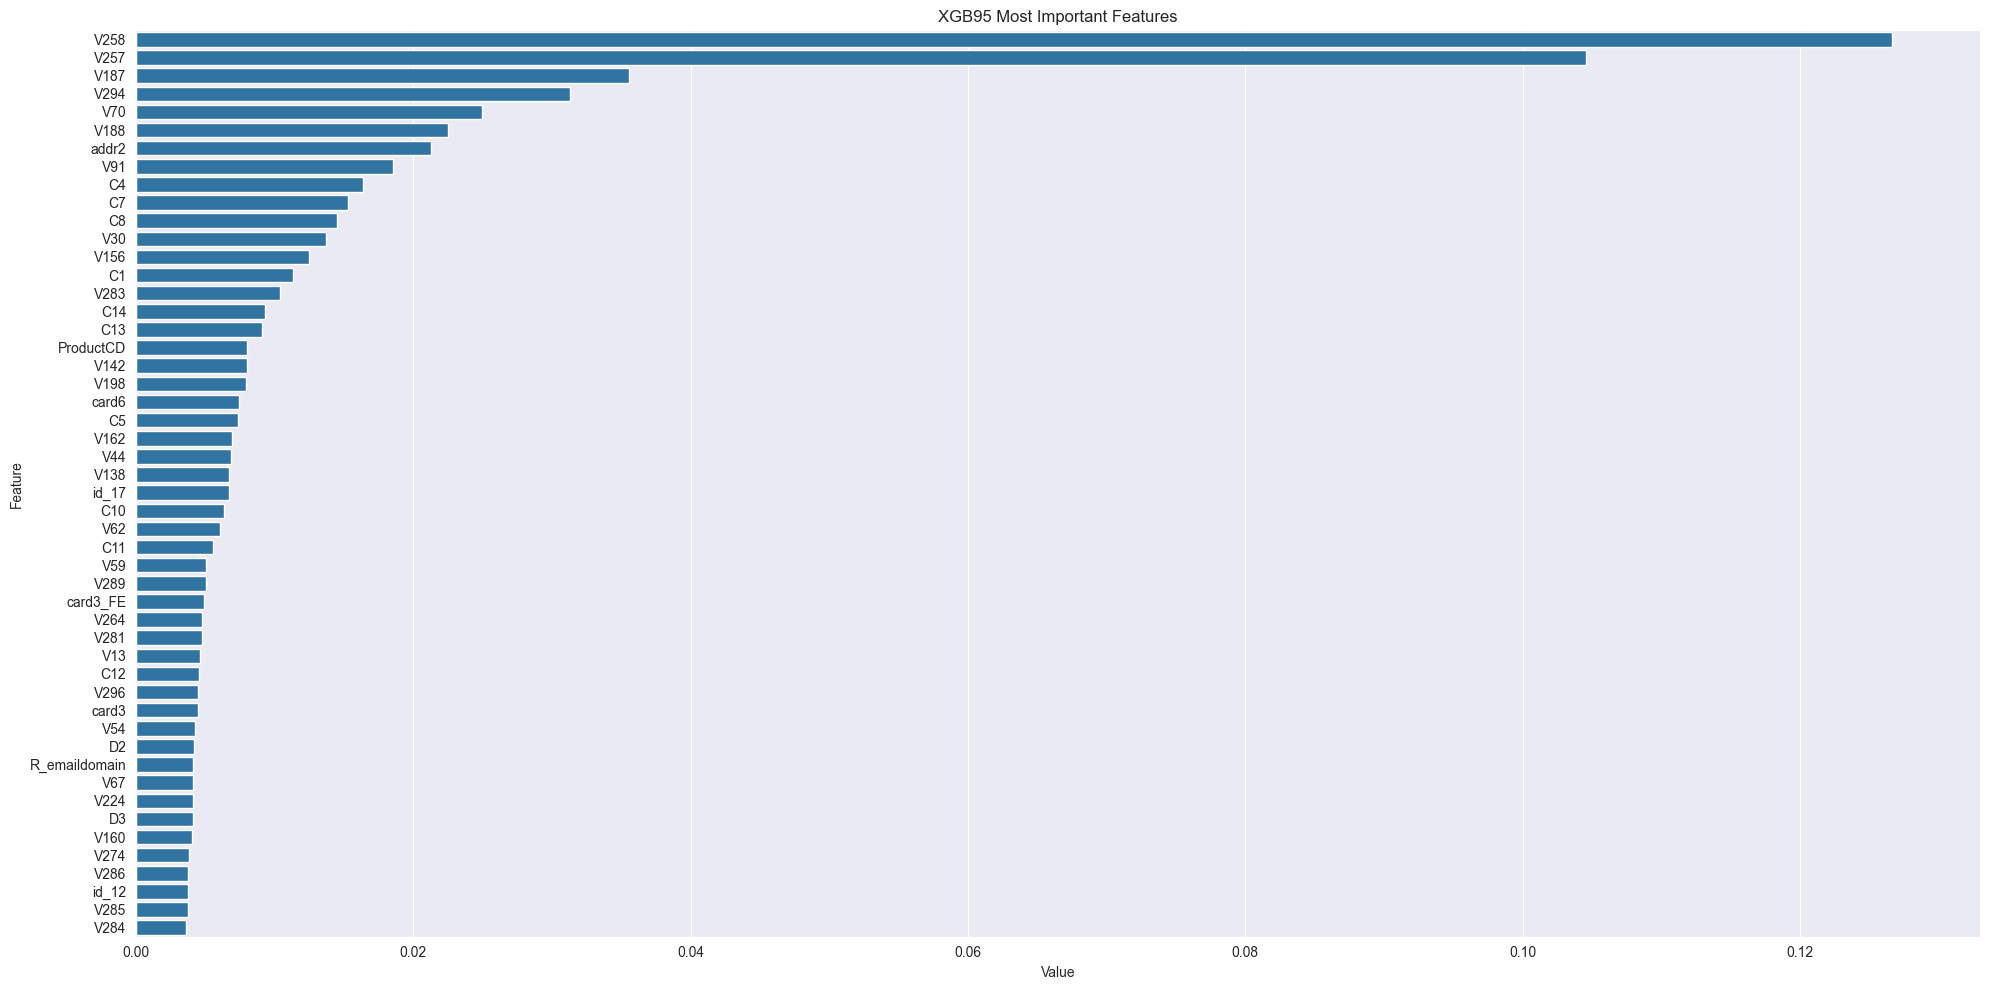

In [46]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()